In [1]:
from tqdm import tqdm
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# Choosing and downloading the dataset

In [2]:
# Cartoon face dataset:
# https://www.kaggle.com/datasets/brendanartley/cartoon-faces-googles-cartoon-set
# Apebase dataset:
# https://github.com/skogard/apebase
# Python script to convert to white background available in assignment files

datasets = ['cartoon64_10000', 'apebase64_10000', 'apebase64_10000_nobg']
dataset_ids = ['1iv_efI5Hy5GO6K7HPBmPG0EzyO8FmTXx', '1r22CIAwbuh1yETfzxoCG5mIrC-sLQcUs', '1qWB7PLwvacwRdWmbrRrVLMzIJupCcBWc']
dataset_entries = dict(zip(datasets, dataset_ids))


### Selecting the dataset ###
# 0 - Cartoon face
# 1 - Apebase (original)
# 2 - Apebase (no background)
dataset_name = datasets[2]


# Method provided by Anjan Chandra Paudel (https://medium.com/@acpanjan/download-google-drive-files-using-wget-3c2c025a8b99)

# Downloading <100MB file from Google Drive
# !wget --no-check-certificate 'https://docs.google.com/uc?export=download&id='{dataset_entries[dataset_name]} -O {dataset_name}.npy

# Files >100MB, so we need a workaround!
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id='{dataset_entries[dataset_name]} -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id="{dataset_entries[dataset_name]} -O {dataset_name}.npy && rm -rf /tmp/cookies.txt


--2023-11-09 21:21:12--  https://docs.google.com/uc?export=download&confirm=t&id=1qWB7PLwvacwRdWmbrRrVLMzIJupCcBWc
Resolving docs.google.com (docs.google.com)... 142.251.171.113, 142.251.171.102, 142.251.171.139, ...
Connecting to docs.google.com (docs.google.com)|142.251.171.113|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-0k-00-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/k63pd1bvm1g4ees0elgejl3h27cbakfn/1699564800000/03912642819301745624/*/1qWB7PLwvacwRdWmbrRrVLMzIJupCcBWc?e=download&uuid=41b8ba1d-2080-46c5-8f1e-a9d3f4a7a445 [following]
--2023-11-09 21:21:13--  https://doc-0k-00-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/k63pd1bvm1g4ees0elgejl3h27cbakfn/1699564800000/03912642819301745624/*/1qWB7PLwvacwRdWmbrRrVLMzIJupCcBWc?e=download&uuid=41b8ba1d-2080-46c5-8f1e-a9d3f4a7a445
Resolving doc-0k-00-docs.googleusercontent.com (doc-0k-00-docs.googleusercontent.com)... 173.194.74.1

# Loading samples and previewing results

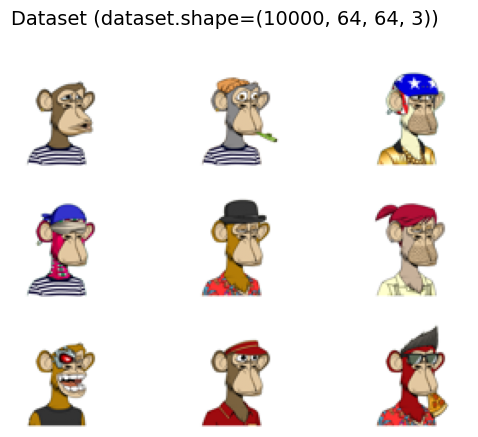

In [3]:
def load_real_samples(scale=False, dataset_name=None):
    X = np.load(f'/content/{dataset_name}.npy')
    # Scale samples in range [-127, 127]
    if scale:
        X = (X - 127.5) * 2
    return X / 255.

# We will use this function to display the output of our models throughout this notebook
def grid_plot(images, epoch='', name='', n=3, save=False, scale=False):
    if scale:
        images = (images + 1) / 2.0
    for index in range(n * n):
        plt.subplot(n, n, 1 + index)
        plt.axis('off')
        plt.imshow(images[index])
    fig = plt.gcf()
    fig.suptitle(name + '  ' + str(epoch), fontsize=14)
    if save:
        filename = 'results/generated_plot_e%03d_f.png' % (epoch+1)
        plt.savefig(filename)
        plt.close()
    plt.show()

dataset = load_real_samples(dataset_name=dataset_name)
grid_plot(dataset[np.random.randint(0, 1000, 9)], name=f'Dataset ({dataset.shape=})', n=3)

## Downsampling the dataset

The functions below will scale your image size from [64,64,3] to [32,32,3].

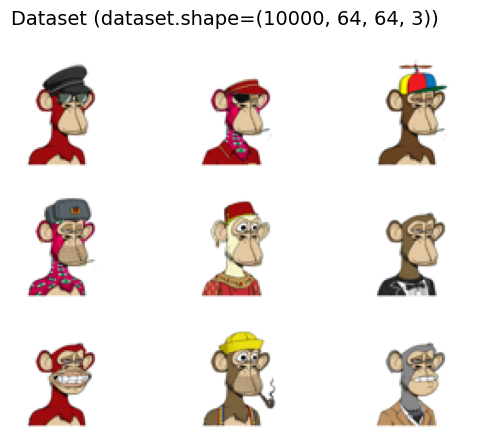

In [4]:
import cv2
import numpy as np

def downsample_image(image):
    """
    Downsamples an image (in numpy format) by a factor of 2 using OpenCV.

    Parameters:
    - image: A numpy array representing the image.

    Returns:
    - A numpy array representing the downsampled image.
    """
    height, width = image.shape[:2]
    return cv2.resize(image, (width*2 // 4, height*2 // 4), interpolation=cv2.INTER_LINEAR)

def downsample_dataset(dataset):
    """
    Downsamples an entire dataset of images by a factor of 2 using OpenCV.

    Parameters:
    - dataset: A list of numpy arrays, where each array represents an image.

    Returns:
    - A list of numpy arrays representing the downsampled images.
    """
    return np.array([downsample_image(image) for image in dataset])

# Downsampling
# We want to keep the resolution to 64x64 so we get a clearer image.
# dataset = downsample_dataset(dataset)

grid_plot(dataset[np.random.randint(0, 1000, 9)], name=f'Dataset ({dataset.shape=})', n=3)

## 2.1. Introduction

The generative models that we are going to cover both have the following components:

1. A downsampling architecture (encoder in case of VAE, and discriminator in case of GAN) to either extract features from the data or model its distribution.
2. An upsampling architecture (decoder for VAE, generator for GAN) that will use some kind of latent vector to generate new samples that resemble the data that it was trained on.

Since we are going to be dealing with images, we are going to use convolutional networks for upsampling and downsampling, similar to what you see below.

<img src="https://i2.wp.com/sefiks.com/wp-content/uploads/2018/03/convolutional-autoencoder.png" width="500">


#### Code for building these components:
Since our dataset is now 64x64 as opposed to 32x32, we add one more down/upsampling layer to account for this.

In [5]:
from tensorflow.keras.layers import Dense, Flatten, Conv2D, Conv2DTranspose, Reshape

out_dim = 42

def build_conv_net(in_shape, out_shape, n_downsampling_layers=4, filters=128, out_activation='sigmoid'):
    """
    Build a basic convolutional network
    """
    model = tf.keras.Sequential()
    default_args=dict(kernel_size=(3,3), strides=(2,2), padding='same', activation='relu')

    model.add(Conv2D(input_shape=in_shape, **default_args, filters=filters))

    for _ in range(n_downsampling_layers):
        model.add(Conv2D(**default_args, filters=filters))

    model.add(Flatten())
    model.add(Dense(out_shape, activation=out_activation))
    model.summary()
    return model


def build_deconv_net(latent_dim, n_upsampling_layers=4, filters=128, activation_out='sigmoid'):
    """
    Build a deconvolutional network for decoding/upscaling latent vectors

    When building the deconvolutional architecture, usually it is best to use the same layer sizes that
    were used in the downsampling network and the Conv2DTranspose layers are used instead of Conv2D layers.
    Using identical layers and hyperparameters ensures that the dimensionality of our output matches the
    shape of our input images.
    """

    model = tf.keras.Sequential()
    model.add(Dense(4 * 4 * 32, input_dim=latent_dim))
    model.add(Reshape((4, 4, 32))) # This matches the output size of the downsampling architecture
    default_args=dict(kernel_size=(3,3), strides=(2,2), padding='same', activation='relu')

    for i in range(n_upsampling_layers):
        model.add(Conv2DTranspose(**default_args, filters=filters))

    # This last convolutional layer converts back to 3 channel RGB image
    model.add(Conv2D(filters=3, kernel_size=(3,3), activation=activation_out, padding='same'))
    model.summary()
    return model

### Convolutional Autoencoder example

Using these two basic building blocks we can now build a Convolutional Autoencoder (CAE).

<img src="https://lilianweng.github.io/lil-log/assets/images/autoencoder-architecture.png" width="500">



Even though it's not a generative model, CAE is a great way to illustrate how these two components (convolutional and deconvolutional networks) can be used together to reconstruct images.

You can view such model as a compression/dimensionality reduction method as each image gets compressed to a vector of 256 numbers by the encoder and gets decompressed back into an image using the decoder network.

If you train the network below, you will see how the input images compare to the deconstructed images (using latent vectors)

In [6]:
def build_convolutional_autoencoder(data_shape, latent_dim, filters=128):
    encoder = build_conv_net(in_shape=data_shape, out_shape=latent_dim, filters=filters)
    decoder = build_deconv_net(latent_dim, activation_out='sigmoid', filters=filters)

    # We connect encoder and decoder into a single model
    autoencoder = tf.keras.Sequential([encoder, decoder])

    # Binary crossentropy loss - pairwise comparison between input and output pixels
    autoencoder.compile(loss='binary_crossentropy', optimizer='adam')

    return autoencoder


# Defining the model dimensions and building it
image_size = dataset.shape[1:]
latent_dim = 512
num_filters = 128
cae = build_convolutional_autoencoder(image_size, latent_dim, num_filters)

for epoch in range(20):
    print('\nEpoch: ', epoch)

    # Note that (X=y) when training autoencoders!
    # In this case we only care about qualitative performance, we don't split into train/test sets
    cae.fit(x=dataset, y=dataset, epochs=1, batch_size=32)

    samples = dataset[np.random.randint(0, 1000, 9)]
    reconstructed = cae.predict(samples)
    grid_plot(samples, epoch, name='Original', n=3, save=False)
    grid_plot(reconstructed, epoch, name='Reconstructed', n=3, save=False)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 128)       3584      
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 128)       147584    
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 128)         147584    
                                                                 
 conv2d_3 (Conv2D)           (None, 4, 4, 128)         147584    
                                                                 
 conv2d_4 (Conv2D)           (None, 2, 2, 128)         147584    
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 512)               2

KeyboardInterrupt: ignored

*Note: You may experiment with the latent dimensionality and number of filters in your convolutional network to see how it affects the reconstruction quality. Remember that this also affects the size of the model and the time it takes to train.*

---
---


## 2. 2. Variational Autoencoders (VAEs)

<img src="https://lilianweng.github.io/lil-log/assets/images/vae-gaussian.png" width="500">

#### Encoder network
This defines the approximate posterior distribution, which takes as input an observation and outputs a set of parameters for specifying the conditional distribution of the latent representation. In this example, we simply model the distribution as a diagonal Gaussian, and the network outputs the mean and log-variance parameters of a factorized Gaussian. We output log-variance instead of the variance directly for numerical stability.

#### Decoder network
This defines the conditional distribution of the observation $z$, which takes a latent sample $z$ as input and outputs the parameters for a conditional distribution of the observation. We model the latent distribution prior  as a unit Gaussian.

#### Reparameterization trick
To generate a sample  for the decoder during training, we can sample from the latent distribution defined by the parameters outputted by the encoder, given an input observation $z$. However, this sampling operation creates a bottleneck because backpropagation cannot flow through a random node.

To address this, we use a reparameterization trick. In our example, we approximate  using the decoder parameters and another parameter  as follows:

$$z = \mu + \sigma\epsilon$$

where $\mu$ and $\sigma$  represent the mean and standard deviation of a Gaussian distribution respectively. They can be derived from the decoder output. The  can be thought of as a random noise used to maintain stochasticity of $z$. We generate  from a standard normal distribution.

The latent variable  is now generated by a function of $\mu$ and $\sigma$ which would enable the model to backpropagate gradients in the encoder through $\mu$ and $\sigma$ respectively, while maintaining stochasticity through $\epsilon$.

#### Implementation

You can see how this trick is implemented below by creating a custom layer by sublassing tf.keras.layers.Layer.
It is then connected to the output of the original encoder architecture and an additional [KL](https://en.wikipedia.org/wiki/Kullback–Leibler_divergence) loss term is introduced.


In [ ]:
class Sampling(tf.keras.layers.Layer):
    """
    Custom layer for the variational autoencoder
    It takes two vectors as input - one for means and other for variances of the latent variables described by a multimodal gaussian
    Its output is a latent vector randomly sampled from this distribution
    """
    def call(self, inputs):
        z_mean, z_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_var) * epsilon

def build_vae(data_shape, latent_dim, filters=128):

    # Building the encoder - starts with a simple downsampling convolutional network
    encoder = build_conv_net(data_shape, latent_dim*2, filters=filters)

    # Adding special sampling layer that uses the reparametrization trick
    z_mean = Dense(latent_dim)(encoder.output)
    z_var = Dense(latent_dim)(encoder.output)
    z = Sampling()([z_mean, z_var])

    # Connecting the two encoder parts
    encoder = tf.keras.Model(inputs=encoder.input, outputs=z)

    # Defining the decoder which is a regular upsampling deconvolutional network
    decoder = build_deconv_net(latent_dim, activation_out='sigmoid', filters=filters)
    vae = tf.keras.Model(inputs=encoder.input, outputs=decoder(z))

    # Adding the special loss term
    kl_loss = -0.5 * tf.reduce_sum(z_var - tf.square(z_mean) - tf.exp(z_var) + 1)
    vae.add_loss(kl_loss/tf.cast(tf.keras.backend.prod(data_shape), tf.float32))

    vae.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), loss='binary_crossentropy')

    return encoder, decoder, vae


In [ ]:
# Training the VAE model

latent_dim = 32
encoder, decoder, vae = build_vae(dataset.shape[1:], latent_dim, filters=128)

# Generate random vectors that we will use to sample our latent space
for epoch in range(20):
    latent_vectors = np.random.randn(9, latent_dim)
    vae.fit(x=dataset, y=dataset, epochs=1, batch_size=8)

    images = decoder(latent_vectors)
    grid_plot(images, epoch, name='VAE generated images (randomly sampled from the latent space)', n=3, save=False)

*Note: again, you might experiment with the latent dimensionality, batch size and the architecture of your convolutional nets to see how it affects the generative capabilities of this model.*

---

## 2.3 Generative Adversarial Networks (GANs)

### GAN architecture
Generative adversarial networks consist of two models: a generative model and a discriminative model.

<img src="https://media.springernature.com/original/springer-static/image/chp%3A10.1007%2F978-1-4842-3679-6_8/MediaObjects/463582_1_En_8_Fig1_HTML.jpg" width="500">

**The discriminator** model is a classifier that determines whether a given image is a real image from the dataset or an image artificially created by the generator model. This is basically a binary classifier that will take the form of a regular convolutional neural network (CNN).

The **generator** model takes vectors of random numbers (noise) as input values  and transforms them into images through a deconvolutional neural network.

Over the course of many training iterations, the weights and biases in the discriminator and the generator are trained through backpropagation. The discriminator learns to tell "real" images of handwritten digits apart from "fake" images created by the generator. At the same time, the generator uses feedback from the discriminator to learn how to produce convincing images that the discriminator can't distinguish from real images.




In [ ]:
from tensorflow.keras.optimizers.legacy import Adam

def build_gan(data_shape, latent_dim, filters=128, lr=0.0002, beta_1=0.5):
    optimizer = Adam(learning_rate=lr, beta_1=beta_1)

    # Usually thew GAN generator has tanh activation function in the output layer
    generator = build_deconv_net(latent_dim, activation_out='tanh', filters=filters)

    # Build and compile the discriminator
    discriminator = build_conv_net(in_shape=data_shape, out_shape=1, filters=filters) # Single output for binary classification
    discriminator.compile(loss='binary_crossentropy', optimizer=optimizer)

    # End-to-end GAN model for training the generator
    discriminator.trainable = False
    true_fake_prediction = discriminator(generator.output)
    GAN = tf.keras.Model(inputs=generator.input, outputs=true_fake_prediction)
    GAN = tf.keras.models.Sequential([generator, discriminator])
    GAN.compile(loss='binary_crossentropy', optimizer=optimizer)

    return discriminator, generator, GAN


### Definining custom functions for training your GANs

---




In [ ]:
def run_generator(generator, n_samples=100):
    """
    Run the generator model and generate n samples of synthetic images using random latent vectors
    """
    latent_dim = generator.layers[0].input_shape[-1]
    generator_input = np.random.randn(n_samples, latent_dim)

    return generator.predict(generator_input)


def get_batch(generator, dataset, batch_size=64):
    """
    Gets a single batch of samples (X) and labels (y) for the training the discriminator.
    One half from the real dataset (labeled as 1s), the other created by the generator model (labeled as 0s).
    """
    batch_size //= 2 # Split evenly among fake and real samples

    fake_data = run_generator(generator, n_samples=batch_size)
    real_data = dataset[np.random.randint(0, dataset.shape[0], batch_size)]

    X = np.concatenate([fake_data, real_data], axis=0)
    y = np.concatenate([np.zeros([batch_size, 1]), np.ones([batch_size, 1])], axis=0)

    return X, y


def train_gan(generator, discriminator, gan, dataset, latent_dim, n_epochs=20, batch_size=64):

    batches_per_epoch = int(dataset.shape[0] / batch_size / 2)
    for epoch in range(n_epochs):
        for batch in tqdm(range(batches_per_epoch), position=0, leave=True):

            # 1) Train discriminator both on real and synthesized images
            X, y = get_batch(generator, dataset, batch_size=batch_size)
            discriminator_loss = discriminator.train_on_batch(X, y)

            # 2) Train generator (note that now the label of synthetic images is reversed to 1)
            X_gan = np.random.randn(batch_size, latent_dim)
            y_gan = np.ones([batch_size, 1])
            generator_loss = gan.train_on_batch(X_gan, y_gan)

        noise = np.random.randn(16, latent_dim)
        images = generator.predict(noise)
        grid_plot(images, epoch+1, name='GAN generated images', n=3, save=False, scale=True)


In [ ]:
## Build and train the model (need around 10 epochs to start seeing some results)

tf.keras.utils.disable_interactive_logging()

# To better understand what the latent vectors are doing, we have reduced the latent dimension size.
# We lose a bit of detail on the generated images, but now each dimension encodes a lot more
# information compared to having a higher number of dimensions, where a change in a single dimension
# doesn't influence the end result in a meaningful way.
latent_dim = 32
discriminator, generator, gan = build_gan(dataset.shape[1:], latent_dim, filters=128)
dataset_scaled = load_real_samples(scale=True, dataset_name=dataset_name)
# For the datasets we want to keep the resolution to 64x64 so we get a clear image.
# dataset_scaled = downsample_dataset(dataset_scaled)

# We train the GAN for 200 epochs to reduce noise as much as possible.
train_gan(generator, discriminator, gan, dataset_scaled, latent_dim, n_epochs=200)

*Note: the samples generated by small GANs are more diverse, when compared to VAEs, however some samples might look strange and do not resemble the data the model was trained on.

# Exploring the latent space
For this example, we sample two random points in latent space and linearly interpolate between them to see how one vector transforms to the other. Doing this we can see how features change when traversing the latent space.

In [ ]:
samples = 9

# sample two random points in latent space
noise = np.random.randn(2, latent_dim)
# create linear interpolation between the points
vecs = np.linspace(*noise, samples)

images = generator.predict(vecs)
grid_plot(images, name='GAN interpolation between random latent vectors', n=3, save=False, scale=True)

# Finding important dimensions
We find important dimensions by setting each other dimension to zero and taking two extreme values for the dimension we want to analyze. By comparing the difference between the results of these latent vectors we can identify which dimensions are important for changing the results.

To do this, we set one dimension to two extreme values, and compare the sum of squares of pixel differences between the images. From this we calculate the mean and standard deviation of these difference magnitudes. We say a dimension is important to the result of the generated output if the difference from that dimension is at least one standard deviation from the mean.

In [ ]:
samples = 2

vecs = np.zeros((samples, latent_dim))
dim_difference = []

for col in range(latent_dim):
  # add noise
  vecs[:, col] = [-4, 4]

  images = generator.predict(vecs)

  image_diff = np.abs(images[0] - images[1])   # absolute difference of two samples
  diff_mag = np.sqrt(np.sum(image_diff**2))    # sqrt of sum of difference squared

  # save element and its magnitude of difference
  dim_difference.append([col, diff_mag])

  # normalize difference between [0...1] for plotting
  image_diff = (image_diff - np.min(image_diff)) / (np.max(image_diff) - np.min(image_diff))

  # create 2x2 grid of generate images, difference and empty image
  images = np.concatenate((images, [image_diff], np.full((1, 64, 64, 3), 1)))

  # reset vectors
  vecs[:, col] = 0

# calculate the mean and std deviation
dim_difference = np.array(dim_difference)
diff_mags = dim_difference[:, 1]
mean, stddev = np.mean(diff_mags), np.std(diff_mags)

# define important dimensions as those at least one standard deviation from mean
important_dims = np.extract(np.abs(dim_difference[:, 1] - mean) > stddev, dim_difference[:, 0]).astype(int)

# Analyzing important dimensions
Using the discovered important dimensions, we now linearly interpolate between extreme values and see what features each dimension encodes.

In [ ]:
samples = 9

vecs = np.zeros((samples, latent_dim))
noise = np.linspace(-4, 4, samples)

for col in important_dims:
  # add noise
  vecs[:, col] = noise

  images = generator.predict(vecs)
  grid_plot(images, col, name='GAN non-zero row=', n=3, save=False, scale=True)

  # reset vectors
  vecs[:, col] = 0

# The extreme case
Just for fun we decided to interpolate over all important dimensions, which gives very extreme results. As you may notice the middle sample is relatively normal, as this is where the latent vector is all zeros, so it is the mean of the latent space.

In [ ]:
samples = 9

vecs = np.zeros((samples, latent_dim))
noise = np.linspace(-4, 4, samples)[:, np.newaxis]

# add noise
vecs[:, important_dims] = noise

images = generator.predict(vecs)
grid_plot(images, name='GAN linear important elements', n=3, save=False, scale=True)

# Interactive plot

Below is an interactive plot that allows you to choose a dimension and deviation to see how certain dimensions change the image.

In [ ]:
samples = 9

from ipywidgets import interact, fixed
import ipywidgets as widgets

dev_range = {'min': -4.0, 'max': 4.0}
sample = np.zeros((1, latent_dim))

def change_dimension(dimension):
  interact(generate_sample, dimension=fixed(dimension), deviation=widgets.FloatSlider(**dev_range, value=sample[0, dimension]))

def generate_sample(dimension, deviation):
  sample[0, dimension] = deviation
  grid_plot(generator.predict(sample), name='GAN custom latent vector', n=1, save=False, scale=True)

@widgets.interact
def interactive_plot():
  interact(change_dimension, dimension=widgets.IntSlider(min=0, max=latent_dim-1, value=0))